In [1]:
from dataclasses import dataclass
import numpy as np
from typing import Tuple, Dict, Callable
import matplotlib.pyplot as plt

from scipy.optimize import root
import random as rd
from itertools import product
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.stats import norm
from numba import jit, njit, int32, float64
import quantecon as qe
from numba.typed import Dict,List
import numba as nb

In [2]:
########### Parameters

beta = 0.992
delta = 0.01
alpha_m = 1.05
phi = 0.5
lambda_m = 0.3
lambda_g = 0.7
gamma = 0
nx = 100
ny = 100
nyg = round(lambda_g*ny)
nym = ny-nyg

In [3]:
@njit
def m_u_v(u,v):
    return( 0.7 *( u**(0.5)) * (v **0.5))
#@njit
#def d_x_y(x,y):
#    return(1)
@njit
def f(x,y,l):
    if l == 'm':
        return(x * y * alpha_m)
    if l == 'g':
        return(x*y)
@njit
def w_x_y(x,y,l):
    if l == 'm':
        return( 0.1 + 0.11 * f(x,y,l) )
    if l == 'g':
        return(  0.1 + 0.1 * f(x,y,l) )


In [19]:
import numpy as np
from numba import types
from numba.experimental import jitclass

# ---- jitclass field spec (all typed) ----
spec = [
    ('x_val',     types.float64[:]),
    ('y_g_val',   types.float64[:]),
    ('y_m_val',   types.float64[:]),
    ('V_e_x_y', types.float64[:, :]),
    ('V_u',       types.float64[:]),
    ('V_p_x_y', types.float64[:, :]),
    ('V_v_y_m',   types.float64[:]),
    ('V_v_y_g',   types.float64[:]),
    ('u',         types.float64),
    ('V',         types.float64),
    ('e',         types.float64),
    ('matches',   types.int64[:, :]),
    ('states_w',  types.int64[:]),
    ('states_f',  types.int64[:]),
    ('d_y',       types.float64[:]),
    ('d_x',       types.float64[:]),
    ('d_xy',      types.float64[:, :]),
    #('seq',       types.ListType(types.ListType(types.float64[:])) ) ,
    ('n_params',  types.int64)
]

n_params =len(spec)
@jitclass(spec)
class ModelCurrent:
    def __init__(self, x_distrib, y_distrib_g, y_distrib_m, matches_distrib = None):
        # Ensure contiguous float64 inputs

        # Unpack columns
        self.x_val = np.asarray(x_distrib, dtype=np.float64)
        self.y_g_val = np.asarray(y_distrib_g, dtype=np.float64)
        self.y_m_val = np.asarray(y_distrib_m, dtype=np.float64)
        nx  = len(x_distrib)
        nyg = len(y_distrib_g)
        nym = len(y_distrib_m)
        ny = nyg+nym
        # ---- Build Cartesian products via tile/repeat (Numba-friendly) ----
        # For "g"

        def cart2mat(a, b):
            na = len(a)
            nb = len(b)
            N  = na * nb
            M  = np.empty((na, nb), np.float64)
            idx = 0
            for i in range(na):
                ai = a[i]
                for j in range(nb):
                    bj = b[j]
                    M[i, j] = np.float64(ai) * np.float64(bj)
            return M
        self.V_e_x_y = cart2mat(x_distrib, y_distrib_g+y_distrib_m)
        self.V_p_x_y =  cart2mat(x_distrib, y_distrib_g+y_distrib_m)

        ##model.V_u: [x_value, 0.5]
        self.V_u = np.full(nx, np.float64(0))

        ## V_v_y_*
        self.V_v_y_g = np.full(nyg, np.float64(0))
        self.V_v_y_m = np.full(nym, np.float64(0))

        ## Scalars
        self.u = np.float64(0)
        self.V = np.float64(0.2)
        self.e = np.float64(1)

        ## 
        matches  = np.empty((nx, ny), np.int64)
        initial_distrib = np.asarray(np.random.choice(ny,min(ny,nx)), dtype=np.int64) 
        for x in range(0,nx):
            for y in range(0, ny):
                if x < len(initial_distrib) and initial_distrib[x] == y:
                    matches[x,y] = 1
                else:
                    matches[x,y]=0
        self.matches = matches
        self.states_w = np.full(nx,np.int64(1))
        self.states_f = np.full(nyg+nym, np.int64(1))
        #

        ## distribution of matches :
        if matches_distrib is not None:
            self.d_xy = matches_distrib
        else:
            self.d_xy = matches/np.sum(matches)
        ## d_y: 
        self.d_y = np.full(nyg + nym, np.float64(0))

        ## d_x: 
        self.d_x = np.full(nx, np.float64(0))

        ### sequence of updated differences of values:
   #     self.seq =  List.empty_list(types.ListType((types.float64[:])) )

        self.n_params = np.int64(n_params)

    #def append_seq_row(self, row):
    #    if row.shape[0] != 9:
    #        raise ValueError(1)   # Numba needs small ints; use codes not strings
    #    # Make a copy to avoid aliasing external buffer
    #    r = np.empty(9, np.float64)
    #    for i in range(9):
    #        r[i] = row[i]
    #    self.seq.append(r)


In [20]:
rd.seed(123)

x_distrib =sorted(np.random.uniform(0,1, nx))

y_distrib_g = sorted(np.random.uniform(0,1,nyg))
y_distrib_m =sorted(np.random.uniform(0,1,nym))

current_model = ModelCurrent(x_distrib,y_distrib_g,y_distrib_m)

In [25]:
@njit
def new_V_u_x(x,model):
    """
    Update value function for unemployed people at time t
    """
    M_u = m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)
    potential_jobs_g = [ model.V_e_x_y[x,y] *model.d_y[y]
                                     for y in range(0, nyg) if model.V_e_x_y[x,y] > model.V_u[x]
                                    and model.V_p_x_y[x,y] > model.V_v_y_g[y] ]
    int_g = [ model.d_y[y] 
                                     for y in range(0, nyg) if model.V_e_x_y[x,y] > model.V_u[x]
                                    and model.V_p_x_y[x,y] > model.V_v_y_g[y] ]
    potential_jobs_m = [ model.V_e_x_y[x,nyg+y] *model.d_y[nyg+y] 
                                     for y in range(0, nym) if model.V_e_x_y[x,nyg+y] > model.V_u[x]
                                    and model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] ]
    int_m = [ model.d_y[nyg+ y] 
                                     for y in range(0, nym) if model.V_e_x_y[x,nyg+y] > model.V_u[x]
                                    and model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] ]

    V = (1/(1-beta*(1-M_u)*(1-delta)*(lambda_g * sum(int_g) + lambda_m * sum(int_m) ))) *( 
                    beta*(1-delta) *M_u * (lambda_g * sum(potential_jobs_g) + lambda_m * sum(potential_jobs_m)))
    return(V)


In [26]:
##### new value function for employed_public
@njit
def new_V_e_x_y(x, y, model):
    """
    Update value function for employed people at time t going into sector g
    """
    if y <nyg:
        sector = 'g'
        y_val = model.y_g_val[y]
    else:
        sector = 'm'
        y_val = model.y_m_val[y-nyg]
    V_t = model.V_e_x_y[x,y]
    M_e = phi* m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)

    potential_jobs_g = [ model.V_e_x_y[x,y_prime] *model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    int_g = [model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    potential_jobs_m =[ model.V_e_x_y[x,nyg+y_prime] *model.d_y[y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] >  V_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]
    int_m = [ model.d_y[y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] > V_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]

    denom = 1 - beta * (1-delta ) * (1 - M_e * (lambda_g * sum(int_g) + lambda_m * sum(int_m) ) )
    flux = gamma * f(model.x_val[x],y_val,sector) + w_x_y(model.x_val[x],y_val,sector) + beta * delta * model.V_u[x] 
    potential_jobs = beta * (1-delta) * M_e * (lambda_g * sum(potential_jobs_g) + lambda_m * sum(potential_jobs_m) )
    V = (flux + potential_jobs)/denom
    return(V)
#plt.plot([y for y in range(0, ny)], [new_V_e_x_y(99, y, current_model) for y in range(0, ny)])

In [27]:
@njit
def new_V_v_y_g(y,model):
    """
    
    """
    if model.V !=0:
        M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    else:
        M_v = 0
    M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    C_u = model.u / (model.u + phi * model.e ) 
    C_e = phi * model.e / (model.u + phi * model.e ) 


    ### matching with employed!:
    potential_unemployed = 0
    int_unemployed = 0
    potential_employed_g = 0
    int_employed_g = 0
    potential_employed_m = 0
    int_employed_m = 0

    for x in range(0, nx):
        if model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_u[x] :
            potential_unemployed = potential_unemployed +  model.V_e_x_y[x,y] *model.d_x[x]
            int_unemployed = int_unemployed +  model.d_x[x]
        for y_prime in range(0, nyg):
            if  model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_e_x_y[x,y]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,y] *model.d_xy[x,y_prime]
                int_employed_g = int_employed_g + model.d_xy[x,y_prime]
        for y_prime in range(0, nym):
            if  model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_e_x_y[x,nyg+y_prime]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,y] *model.d_xy[x,nyg+y_prime]
                int_employed_m = int_employed_m + model.d_xy[x,nyg+y_prime]


    denom = 1/ ( 1 - beta * ( 1 - (1 - delta) * M_v * ( C_u * int_unemployed + C_e * ( lambda_g * int_employed_g + lambda_m * int_employed_m ))))
    num = beta * ( 1 - delta ) * M_v * ( C_u * potential_unemployed + C_e * ( lambda_g * potential_employed_g  + lambda_m * potential_employed_m  ) )
    V = num/denom
    return(V)


In [28]:
@njit
def new_V_v_y_m(y,model):
    """
    
    """
    if model.V !=0:
        M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    else:
        M_v = 0
    C_u = model.u / (model.u + phi * model.e ) 
    C_e = phi * model.e / (model.u + phi * model.e ) 


    ### matching with employed!:
    potential_unemployed = 0
    int_unemployed = 0
    potential_employed_g = 0
    int_employed_g = 0
    potential_employed_m = 0
    int_employed_m = 0

    for x in range(0, nx):
        if model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_u[x] :
            potential_unemployed = potential_unemployed +  model.V_e_x_y[x,nyg+y] *model.d_x[x]
            int_unemployed = int_unemployed +  model.d_x[x]
        for y_prime in range(0, nyg):
            if  model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_e_x_y[x,y]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,nyg+y] *model.d_xy[x,y_prime]
                int_employed_g = int_employed_g + model.d_xy[x,y_prime]
        for y_prime in range(0, nym):
            if  model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_e_x_y[x,nyg+y_prime]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,nyg+y] *model.d_xy[x,nyg+y_prime]
                int_employed_m = int_employed_m + model.d_xy[x,nyg+y_prime]


    denom = 1/ ( 1 - beta * ( 1 - (1 - delta) * M_v * ( C_u * int_unemployed + C_e * ( lambda_g * int_employed_g + lambda_m * int_employed_m ))))
    num = beta * ( 1 - delta ) * M_v * ( C_u * potential_unemployed + C_e * ( lambda_g * potential_employed_g  + lambda_m * potential_employed_m  ) )
    V = num/denom
    return(V)


In [29]:
##### new value function for employer
@njit
def new_V_p_x_y(x, y, model, debug = False):
    """
    Update value function for employers at time t
    """
    if y <nyg:
        sector = 'g'
        y_val = model.y_g_val[y]
        V_v =  model.V_v_y_g[y] 
    else:
        sector = 'm'
        y_val = model.y_m_val[y-nyg]
        V_v =  model.V_v_y_m[y-nyg] 
    V_t = model.V_e_x_y[x,y]
    M_e = phi* m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)

    int_g = [model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    int_m = [ model.d_y[y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] > V_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]

    denom = 1 - beta * (1-delta ) * (1 - M_e * ( 1-  lambda_g * sum(int_g) - lambda_m * sum(int_m) ) )
    flux = f(model.x_val[x],y_val,sector) - w_x_y(model.x_val[x],y_val,sector) + beta * (delta * ( 1+ M_e ) +  (1-delta ) * M_e * ( 1-  lambda_g * sum(int_g) - lambda_m * sum(int_m) ) )  * V_v
    V = (flux )/denom
    if debug == True:
        print(denom)
        print(flux)
        print(sum(int_g))
        print(int_m)
    return(V)


In [30]:
@njit
def movement(model, debug = False):
    """
    Define movement at each period
    """

    new_d_xy = model.d_xy
    ### Variables for debug
    if debug == True:
        lost_matches = 0
        matches_unemp = 0
        matches_emp = 0

    ### First round : jobs exogeneously disappear
    
    for x in range(0,nx):
        for y in range(0, nyg+nym):
            if model.matches[x,y] ==1:
                new_status = np.float64(np.searchsorted(np.cumsum(np.asarray([delta, 1-delta], dtype = np.float64)), np.random.rand(1))[0])
                model.matches[x,y] = new_status
                if new_status == 0:
                    model.d_x[x] = np.float64(1)
                    model.d_y[y] = np.float64(1)
                    if debug == True:
                        lost_matches +=1

    if debug == True:
        print(f'Lost matches: {lost_matches}')

    
    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) >0:
        model.d_x = model.d_x/np.sum(model.d_x)
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) > 0:
        model.d_y = model.d_y/np.sum(model.d_y)
    #### Update states
    new_e = np.mean(np.sum(model.matches, axis = 0))
    new_u = 1-new_e
    new_V = 1-np.mean(np.sum(model.matches, axis = 1))
    model.e = new_e
    model.u = new_u
    model.V = new_V
    #### Update value functions for unmatched agents
    for x in range(0, nx):
        model.V_u[x] = new_V_u_x(x, model)
    for y in range(0,nym):
        model.V_v_y_m[y] = new_V_v_y_m(y, model)
    for y in range(0,nyg):
        model.V_v_y_g[y] = new_V_v_y_g(y, model)

    if debug == True:
        print('Unmatched agent value functions updated')
        print(m_u_v(new_u,new_V))
    ### Second round : matches from unemployment occur

    # random meeting of unmatched agents 
    unmatched_w =   np.asarray([x for x in range(0, nx) if model.d_x[x] >0]  , dtype = np.int64)
    unmatched_f_g = np.asarray([y for y in range(0, nyg) if model.d_y[y] >0], dtype = np.int64)
    unmatched_f_m = np.asarray([y for y in range(nyg, nym+nyg) if model.d_y[y] >0], dtype = np.int64)
    n_unmatched_w = unmatched_w.shape[0]
    n_unmatched_f = unmatched_f_g.shape[0] + unmatched_f_m.shape[0]

    if debug == True:
        print(f'{n_unmatched_w} workers and {n_unmatched_f} firms to match.')
   
    if n_unmatched_w >0 and n_unmatched_f >0:
        for x in unmatched_w:
            matched = 0
            meet = np.searchsorted(np.cumsum(np.asarray([1-m_u_v(new_u,new_V),m_u_v(new_u,new_V)], dtype = np.float64)), np.random.rand(1))[0]
            if meet == 1:
                type_meet = np.int64(np.searchsorted(np.cumsum(np.asarray([lambda_g,lambda_m], dtype =np.float64) ), np.random.rand(1))[0])
                if type_meet == 0: ## meeting unmatched firm from type g
                    try:
                        y = np.random.choice(unmatched_f_g,1)[0]
                        if matched == 0 and model.V_e_x_y[x,y] >= model.V_u[x] and model.V_p_x_y[x,y]>= model.V_v_y_g[y]:
                            model.matches[x,y] = 1
                            matched = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            if debug == True:
                                matches_unemp +=1
                    except:
                        matched = 0
                else:  ## meeting unmatched firm from type m
                    try:
                        y = np.random.choice(unmatched_f_m,1)[0]
                        if matched == 0 and model.V_e_x_y[x,y] >= model.V_u[x] and model.V_p_x_y[x,y]>= model.V_v_y_m[y-nyg]:
                            model.matches[x,y] = 1
                            matched = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            if debug == True:
                                matches_unemp +=1
                    except:
                        matched = 0
    if debug == True:
        print(f'New matches from unemployment: {matches_unemp}')
    new_e = np.mean(np.sum(model.matches, axis = 0))
    new_u = 1-new_e
    new_V = 1-np.mean(np.sum(model.matches, axis = 1))
    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) !=0:
        model.d_x = model.d_x/np.sum(model.d_x)
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) !=0:
        model.d_y = model.d_y/np.sum(model.d_y)
    model.e = new_e
    model.u = new_u
    model.V = new_V

    # random meeting of matched agents
    matched_w = np.asarray([x for x in range(0, nx) if model.d_x[x] ==0]  , dtype = np.int64)
    current_match_w =np.argmax(model.matches, axis=1)
    unmatched_f_g = np.asarray([y for y in range(0, nyg) if model.d_y[y] >0], dtype = np.int64)
    unmatched_f_m = np.asarray([y for y in range(nyg, nym+nyg) if model.d_y[y] >0], dtype = np.int64)
    n_matched_w = matched_w.shape[0]
    n_unmatched_f = unmatched_f_g.shape[0] + unmatched_f_m.shape[0]

    if debug == True:
        print(f'{n_matched_w} workers and {n_unmatched_f} firms to potentially match.')
    if n_matched_w >0 and n_unmatched_f >0:
        for x in matched_w:
            rematch = 0
            meet = np.searchsorted(np.cumsum(np.asarray([1- phi * m_u_v(new_u,new_V), phi * m_u_v(new_u,new_V)], dtype = np.float64)), np.random.rand(1))[0]
            if meet == 1:
                type_meet = np.int64(np.searchsorted(np.cumsum(np.asarray([lambda_g,lambda_m], dtype =np.float64) ), np.random.rand(1))[0])
                if type_meet == 0:
                    try:
                        y = np.random.choice(unmatched_f_g,1)[0]
                        if rematch == 0 and model.d_y[y] == 1 and model.V_e_x_y[x,y] >= model.V_e_x_y[x,y] and model.V_p_x_y[x,current_match_w[x]] >= model.V_v_y_g[y]:
                            model.matches[x,y] = 1
                            model.matches[x,current_match_w[x]] = 0
                            rematch = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            model.d_y[current_match_w[x]] = np.float64(1)
                            if debug == True:
                                matches_emp +=1
                    except:
                        rematch = 0
        
                else:
                    try:
                        y = np.random.choice(unmatched_f_m,1)[0]
                        if rematch == 0 and model.d_y[y] == 1 and model.V_e_x_y[x,y] >= model.V_e_x_y[x,y] and model.V_p_x_y[x,current_match_w[x]] >= model.V_v_y_m[y-nyg]:
                            model.matches[x,y] = 1
                            model.matches[x,current_match_w[x]] = 0
                            rematch = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            model.d_y[current_match_w[x]] = np.float64(1)
                            if debug == True:
                                matches_emp +=1
                    except:
                        rematch = 0

    if debug == True:
        print(f'New matches from employment: {matches_emp}')

    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) !=0:
        model.d_x = model.d_x/np.sum(model.d_x)
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) !=0:
        model.d_y = model.d_y/np.sum(model.d_y)

    model.d_xy = model.matches/np.sum(model.matches)

    model.e = np.mean(np.sum(model.matches, axis = 0))
    model.u = 1-new_e
    model.V = 1-np.mean(np.sum(model.matches, axis = 1))


    ### Recompute value functions for matched agents
    for x in range(0,nx):
        for y in range(0, nyg+nym):
            model.V_e_x_y[x,y] = new_V_e_x_y(x,y,model)
            model.V_p_x_y[x,y] = new_V_p_x_y(x,y,model)
    

    return('ok')
    

In [31]:
rd.seed(123)

x_distrib =sorted(np.random.uniform(0,1, nx))

y_distrib_g = sorted(np.random.uniform(0,1,nyg))
y_distrib_m =sorted(np.random.uniform(0,1,nym))



In [32]:
#reinitialise

current_model = ModelCurrent(x_distrib,y_distrib_g,y_distrib_m)

In [33]:
np.max(current_model.matches, axis=0)

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

In [34]:
np.sum(current_model.matches, axis = 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [36]:
movement(current_model, True)

Lost matches: 1
Unmatched agent value functions updated
0.007000000000000007
1 workers and 1 firms to match.
New matches from unemployment: 0
99 workers and 1 firms to potentially match.
New matches from employment: 0


'ok'

In [45]:
new_V_u_x = []
all_seq = []
for i in range(500):
    movement(current_model, True)
    current_V_u_x = np.copy(current_model.V_u)
    current_V_e_x_y = np.copy(current_model.V_e_x_y)
    current_V_p_x_y = np.copy(current_model.V_p_x_y)
    current_V_v_y_g = np.copy(current_model.V_v_y_g)
    current_V_v_y_m = np.copy(current_model.V_v_y_m)
    current_matches = np.copy(current_model.matches)
    
    current_e = np.copy(current_model.e)
    current_V = np.copy(current_model.V)
    current_u = np.copy(current_model.u)
    row_seq ={ 'e' : current_e
              ,'V' : current_V
              ,'u' : current_u
              ,'V_u' : current_V_u_x
              ,'V_e_x_y' : current_V_e_x_y
              ,'V_p_x_y' : current_V_p_x_y
              ,'V_v_y_g' : current_V_v_y_g
              ,'V_v_y_m' : current_V_v_y_m
              ,'matches' : current_matches
              }
    all_seq.append(row_seq)

Lost matches: 0
Unmatched agent value functions updated
0.18900000000000003
27 workers and 18 firms to match.
New matches from unemployment: 3
76 workers and 15 firms to potentially match.
New matches from employment: 0
Lost matches: 0
Unmatched agent value functions updated
0.16799999999999998
24 workers and 15 firms to match.
New matches from unemployment: 0
76 workers and 15 firms to potentially match.
New matches from employment: 0
Lost matches: 0
Unmatched agent value functions updated
0.16799999999999998
24 workers and 15 firms to match.
New matches from unemployment: 1
77 workers and 14 firms to potentially match.
New matches from employment: 0
Lost matches: 3
Unmatched agent value functions updated
0.18200000000000002
26 workers and 17 firms to match.
New matches from unemployment: 0
74 workers and 17 firms to potentially match.
New matches from employment: 0
Lost matches: 0
Unmatched agent value functions updated
0.18200000000000002
26 workers and 17 firms to match.
New matche

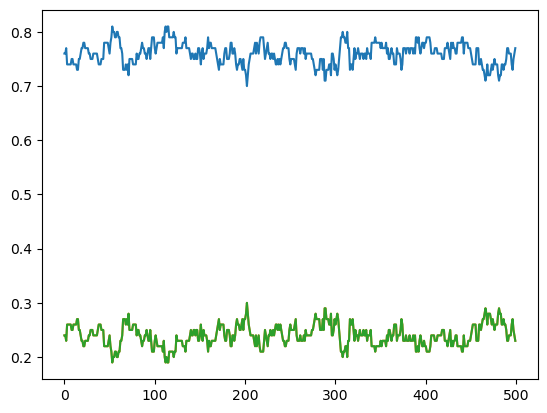

In [47]:
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['e'] for i in range(len(all_seq))])
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['V'] for i in range(len(all_seq))])
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['u'] for i in range(len(all_seq))])

In [ ]:
x_indices, y_indices = np.where(np.asarray([x[0:nyg] for x in current_model.matches] )== 1)
np.corrcoef(x_indices, y_indices)

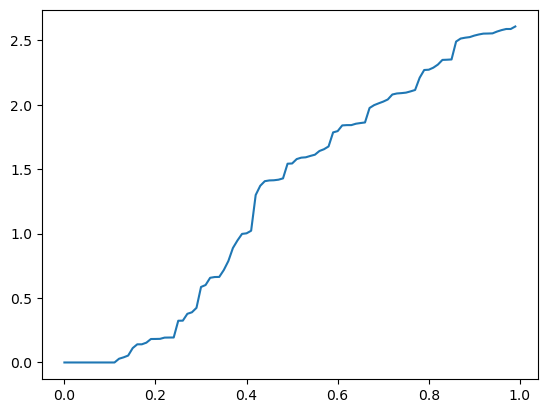

In [59]:
#plt.plot([i for i in range(nx)], [np.mean(V_u_x, axis = 0)[i] for i in range(nx)])
plt.plot([i/nx for i in range(nx)], [
    np.mean([all_seq[j]['V_u'][i] for j in range(len(all_seq))], axis = 0)for i in range(nx)])

In [60]:
x_indices, y_indices = np.where(np.asarray([x[nyg:nyg+nym] for x in current_model.matches] )== 1)
np.corrcoef(x_indices, y_indices)

array([[ 1.        , -0.38581302],
       [-0.38581302,  1.        ]])

In [61]:
np.asarray([x[nyg:nyg+nym] for x in current_model.matches] )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [67]:
np.mean([all_seq[i]['e'] for i in range(200,len(all_seq))])* delta 

0.007580333333333335

In [72]:
(1 - delta ) * np.mean([all_seq[i]['u'] for i in range(200,len(all_seq))]) * m_u_v(np.mean([all_seq[i]['u'] for i in range(200,len(all_seq))]),
                                                                                     np.mean([all_seq[i]['V']for i in range(200,len(all_seq))]))

0.04057367237

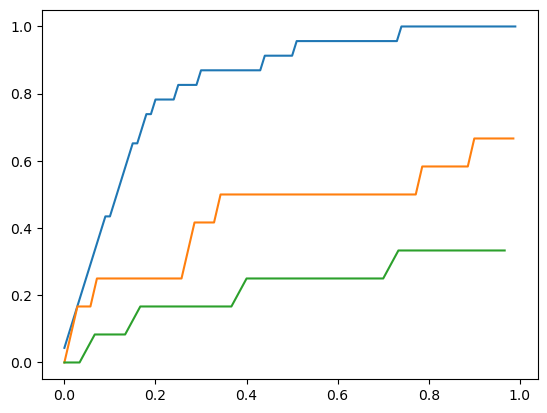

In [73]:
plt.plot([i/len(current_model.d_x) for i in range(len(current_model.d_x))], np.cumsum([current_model.d_x[i] for i in range(len(current_model.d_x))]))
plt.plot([i/nyg for i in range(nyg)], np.cumsum([current_model.d_y[i] for i in range(nyg)]))
plt.plot([i/(nym) for i in range(0,nym)], np.cumsum([current_model.d_y[i] for i in range(nyg,nyg+nym)]))


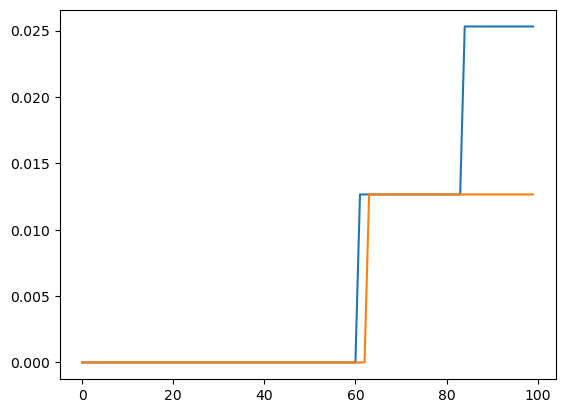

In [32]:
plt.plot([i for i in range(len(current_model.d_x))], np.cumsum([current_model.d_xy[i,90] for i in range(len(current_model.d_x))]))
plt.plot([i for i in range(len(current_model.d_y))], np.cumsum([current_model.d_xy[90,i] for i in range(len(current_model.d_y))]))


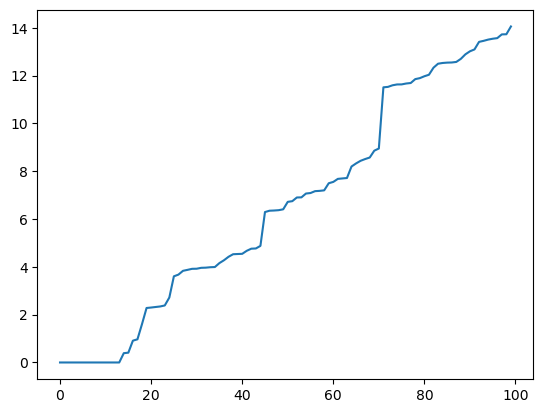

In [33]:
plt.plot([x for x in  range(0,nx)], [current_model.V_u[x] for x in range(0, nx)])

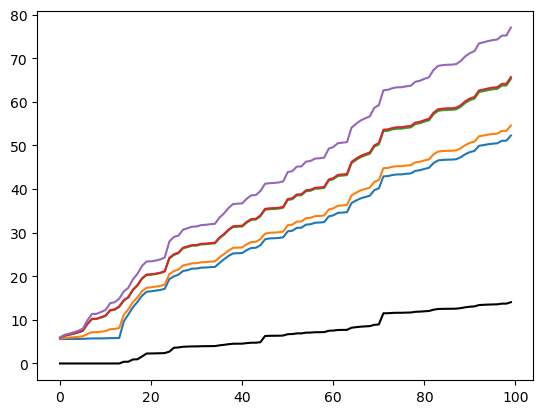

In [34]:
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,0] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,19] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,59] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,60] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,99] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_u[x] for x in range(0, nx)], color= 'black')

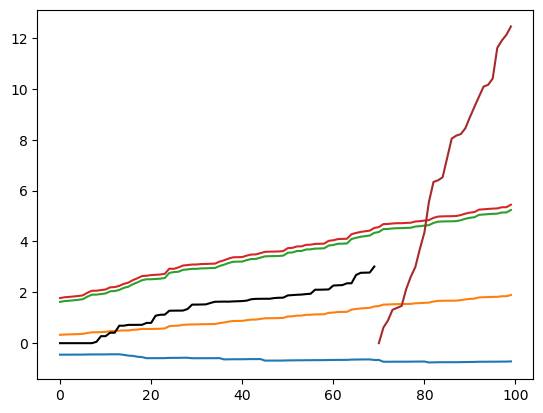

In [35]:
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,0] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,19] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,59] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,60] for x in range(0, nx)])
#plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,99] for x in range(0, nx)])
plt.plot([x for x in  range(0,nyg)], [current_model.V_v_y_g[x] for x in range(0, nyg)], color = 'black')
plt.plot([x for x in  range(nyg,nyg+nym)], [current_model.V_v_y_m[x] for x in range(0, nym)], color = 'brown')


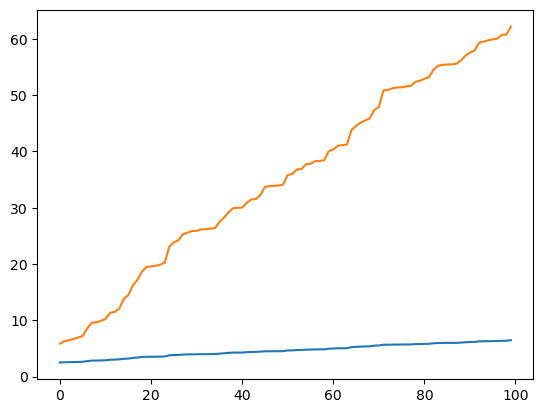

In [36]:
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,69] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,50] for x in range(0, nx)])


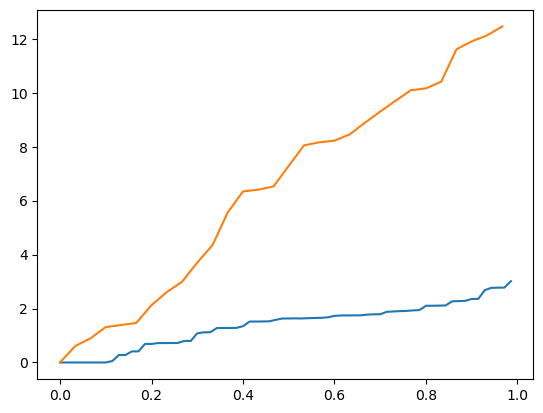

In [37]:
plt.plot([x/nyg for x in  range(0,nyg)], [current_model.V_v_y_g[x] for x in range(0, nyg)])
plt.plot([x/nym for x in  range(0,nym)], [current_model.V_v_y_m[x] for x in range(0, nym)])
